# Evaluate Benchbase Result

About the benchmark:
> TPC-C involves a mix of five concurrent transactions of different types and complexity either executed on-line or queued for deferred execution. The database is comprised of nine types of tables with a wide range of record and population sizes. TPC-C is measured in transactions per minute (tpmC). While the benchmark portrays the activity of a wholesale supplier, TPC-C is not limited to the activity of any particular business segment, but, rather represents any industry that must manage, sell, or distribute a product or service.

<img src="https://raw.githubusercontent.com/wiki/cmu-db/benchbase/img/tpcc.png" alt="drawing" width="600"/>

References:
1. https://github.com/cmu-db/benchbase/wiki/TPC-C
1. http://www.vldb.org/pvldb/vol7/p277-difallah.pdf


## Import Packages

In [16]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown
import seaborn as sns

#import dbmsbenchmarker
#import bexhoma
from bexhoma import evaluators

%matplotlib inline

In [17]:
code = "1743102156"
path = "C:\\data\\benchmarks\\"

### Start Evaluation

In [18]:
evaluation = evaluators.benchbase(code=code, path=path)

In [19]:
df_benchmarks = evaluation.get_df_benchmarking()
#df = df[df.columns.drop(list(df.filter(regex='FAILED')))]
df_benchmarks = evaluation.benchmarking_set_datatypes(df_benchmarks)
df_benchmarks.T

connection_pod,Citus-1-1-1024-1-1,Citus-1-1-1024-2-1,Citus-1-1-1024-2-2,Citus-1-1-1024-3-1,Citus-1-1-1024-3-2,Citus-1-1-1024-3-3,Citus-1-1-1024-3-4,Citus-1-1-1024-4-1,Citus-1-1-1024-4-2,Citus-1-1-1024-4-3,Citus-1-1-1024-4-4,Citus-1-1-1024-4-5,Citus-1-1-1024-4-6,Citus-1-1-1024-4-7,Citus-1-1-1024-4-8
connection,Citus-1-1-1024-1,Citus-1-1-1024-2,Citus-1-1-1024-2,Citus-1-1-1024-3,Citus-1-1-1024-3,Citus-1-1-1024-3,Citus-1-1-1024-3,Citus-1-1-1024-4,Citus-1-1-1024-4,Citus-1-1-1024-4,Citus-1-1-1024-4,Citus-1-1-1024-4,Citus-1-1-1024-4,Citus-1-1-1024-4,Citus-1-1-1024-4
configuration,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024
experiment_run,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
client,1,2,2,3,3,3,3,4,4,4,4,4,4,4,4
pod,qhrlt.dbmsbenchmarker,kbxbx.dbmsbenchmarker,lf8fd.dbmsbenchmarker,62jlb.dbmsbenchmarker,dr2mn.dbmsbenchmarker,fzg6r.dbmsbenchmarker,qlr9m.dbmsbenchmarker,7cznf.dbmsbenchmarker,9l4jv.dbmsbenchmarker,cmh56.dbmsbenchmarker,gsfxk.dbmsbenchmarker,kj68v.dbmsbenchmarker,m5t6r.dbmsbenchmarker,wzb9b.dbmsbenchmarker,zbhsz.dbmsbenchmarker
pod_count,1,2,2,4,4,4,4,8,8,8,8,8,8,8,8
bench,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc
profile,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres
target,16384,8192,8192,4096,4096,4096,4096,2048,2048,2048,2048,2048,2048,2048,2048
time,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0


## Get Benchmarking Result

In [20]:
df_aggregated = evaluation.benchmarking_aggregate_by_parallel_pods(df_benchmarks)
experiment_run = 1

In [21]:
cut_at = 0

#pod_count = 16
#experiment_run = 1
#target = 0
#threads = 128


def plot_timeseries(df_aggregated, metric, pod_count, experiment_run, target, terminals, smoothing=0):
    df = df_aggregated.copy()
    if experiment_run > 0:
        df = df[df['experiment_run'] == experiment_run]
    df = df[df['target'] == target]
    df = df[df['terminals'] == terminals]
    df_subset = df[df['pod_count'] == pod_count]
    df_subset = df_subset[~df_subset.duplicated(subset=['target'], keep='last')]
    client = df_subset['client'].iloc[0]
    plot_measures(metric, smoothing=smoothing, preset_experiment_run=experiment_run, preset_client=client)

def plot_measures(metric, smoothing=0, preset_experiment_run=0, preset_client=0):
    display(Markdown(f'# Metric {metric}'))
    list_configurations = list(df_benchmarks['configuration'].unique())    
    for configuration in list_configurations:
        display(Markdown(f'## Configuration {configuration}'))
        list_experiment_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration]['experiment_run'].unique()))
        for experiment_run in list_experiment_runs:
            if preset_experiment_run > 0:
                if preset_experiment_run != experiment_run:
                    continue
            display(Markdown(f'### Experiment run {experiment_run}'))
            list_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration][df_benchmarks['experiment_run'] == experiment_run]['client'].unique()))
            #list_targets = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration][df_benchmarks['experiment_run'] == experiment_run]['target'].unique()))
            num_runs = len(list_runs)
            # Create a 2-column grid layout
            n_cols = 2
            if preset_client > 0:
                n_rows = 1
            else:
                n_rows = num_runs
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows), sharex=True)
            fig.suptitle(f"{metric}", fontsize=16)#, fontweight="bold")
            # Flatten axes for easy iteration (handles cases with n_rows == 1 or n_cols == 1)
            axes = axes.flatten()
            i = 0
            for client in list_runs:
                if preset_client > 0:
                    if preset_client != client:
                        continue
                #################################
                # show plots with aggregated line
                #################################
                # filter data for this run
                df_part = df_benchmarks[df_benchmarks['configuration'] == configuration]
                df_part = df_part[df_part['experiment_run'] == (experiment_run)]
                df_part = df_part[df_part['client'] == (client)]
                df_total = evaluation.get_benchmark_logs_timeseries_df_aggregated(metric=metric, configuration=configuration, client=client, experiment_run=experiment_run)
                terminals = df_part['terminals'].sum()
                pod_count = df_part['pod_count'].mean()
                target = df_part['target'].sum()
                # Compute the time spans
                time_spans = df_total.index.to_series().diff().shift(-1).fillna(0)  # Difference between consecutive time indices
                # Weighted average: Multiply each value by its duration and sum
                weighted_sum = (df_total[metric].multiply(time_spans, axis=0)).sum().sum()  # Multiply each value by its time span, sum all values
                total_time = time_spans.sum()  # Total time span
                # Compute the weighted average
                weighted_average = weighted_sum / total_time
                df_total['avg'] = weighted_average
                df_total = df_total.rename(columns={'avg': f'avg={weighted_average}'})
                #df_total = df_total.fillna(0)
                # optionally smoothen graph
                if smoothing > 0:
                    df_total[metric] = df_total[metric].rolling(window=smoothing, min_periods=1).mean()
                # optionally leave out data at the end (cool down)
                if cut_at > 0:
                    df_total = df_total[:-cut_at]
                # generate plot
                title = "{}/{} terminals - target = {}".format(terminals, int(pod_count), target)
                ax = axes[i]
                i = i + 1
                max_value = df_total[metric].max()
                #print(max_value)
                df_total.plot(title=title, ax=ax, ylim=(0,max_value*1.1), use_index=True)
                last_x = df_total.index[-1] # Get the last datapoint's x-coordinate (the last index)
                ax.axvline(x=last_x, color='red', linestyle='--', label='Last Datapoint') # Add a vertical line at the last datapoint
                ###############################
                # show plots with lines per pod
                ###############################
                df_list = evaluation.get_benchmark_logs_timeseries_df_single(metric=metric, configuration=configuration, client=client, experiment_run=experiment_run)
                # collect in one dataframe
                df_total = pd.DataFrame()
                j=1
                max_value = 0
                for df in df_list:
                    # optionally leave out data at the end (cool down)
                    if cut_at > 0:
                        df_tmp = df[metric][:-cut_at]
                    else:
                        df_tmp = df[metric]
                    df_single = pd.DataFrame(df_tmp)
                    if max_value < df_single[metric].max():
                        max_value = df_single[metric].max()
                    df_single.columns=["pod "+str(j)]
                    df_total = pd.merge(df_total, df_single, how='outer', left_index=True, right_index=True)
                    j = j + 1
                #print(df_combined)
                # Compute the time spans
                time_spans = df_total.index.to_series().diff().shift(-1).fillna(0)  # Difference between consecutive time indices
                weighted_sum = (df_total.multiply(time_spans, axis=0)).sum().sum()  # Multiply each value by its time span, sum all values
                total_time = time_spans.sum()  # Total time span
                # Compute the weighted average
                weighted_average = weighted_sum / total_time / len(df_list)
                df_total['avg'] = weighted_average
                df_total = df_total.rename(columns={'avg': f'avg={weighted_average}'})
                #df_total = df_total.fillna(0)
                # optionally smoothen graph
                if smoothing > 0:
                    df_total = df_total.rolling(window=smoothing, min_periods=1).mean()
                # generate plot
                title = "{}/{} terminals - target = {}".format(terminals, int(pod_count), target)
                ax = axes[i]
                i = i + 1
                df_total.plot(title=title, ax=ax, ylim=(0,max_value*1.1), use_index=True, legend=False)
                last_x = df_total.index[-1] # Get the last datapoint's x-coordinate (the last index)
                ax.axvline(x=last_x, color='red', linestyle='--', label='Last Datapoint') # Add a vertical line at the last datapoint
            # Hide any unused subplots
            for j in range(num_runs*2, len(axes)):
                fig.delaxes(axes[j])
            plt.tight_layout()
            filename = f"plot_{preset_experiment_run}_{preset_client}_{metric}.png".replace("\\","").replace("/","").replace(":","")
            #df2img.save_dataframe(styled_df, filename="styled_table.png")
            plt.savefig(filename, dpi=300, bbox_inches="tight")
            plt.show()

def plot_heatmap(df_aggregated, metric, pod_count, experiment_run, vmin_value=None, vmax_value=None):
    #metric = '[OVERALL].Throughput(ops/sec)'
    #pod_count = 1
    #experiment_run = 1
    df = df_aggregated[['experiment_run', 'threads', 'target', 'pod_count', metric]]
    df = df[df['pod_count'] == pod_count]
    df = df[df['experiment_run'] == experiment_run]
    df = df[~df.index.duplicated(keep='last')]
    df = df[~df.duplicated(subset=['threads', 'target'], keep='last')]
    #print(df)
    df = df.pivot(index='threads', columns='target', values=metric)
    #display(df.style.background_gradient(cmap='Blues', axis=None))
    styled_df = df.style.background_gradient(cmap='Blues', axis=None).set_caption(metric)
    #df.style.background_gradient(cmap='Blues', axis=None).set_caption(metric)
    #df.style.background_gradient()
    #display(df)
    # Set up the figure size
    plt.figure(figsize=(10, 4))
    # Create the heatmap
    if vmin_value is not None and vmax_value is not None:
        ax = sns.heatmap(df, annot=True, cmap="Blues", fmt=".0f", linewidths=0.5, annot_kws={"size": 7}, vmin=vmin_value, vmax=vmax_value)
    else:
        ax = sns.heatmap(df, annot=True, cmap="Blues", fmt=".0f", linewidths=0.5, annot_kws={"size": 7})
    ax.set_title(metric)
    # Save as PNG
    filename = (f"heatmap_{metric}_{pod_count}_{experiment_run}.png").replace("\\","").replace("/","").replace(":","")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    # Show the plot (optional)
    plt.show()


def plot_heatmap_compare(df_aggregated, metric, pod_count_1, pod_count_2, experiment_run, vmin_value=None, vmax_value=None):
    df = df_aggregated[['experiment_run', 'threads', 'target', 'pod_count', metric]]
    df = df[df['pod_count'] == pod_count_1]
    df = df[df['experiment_run'] == experiment_run]
    df = df[~df.index.duplicated(keep='last')]
    df = df[~df.duplicated(subset=['threads', 'target'], keep='last')]
    #print(df)
    df_1 = df.pivot(index='threads', columns='target', values=metric)
    pod_count = 8
    df = df_aggregated[['experiment_run', 'threads', 'target', 'pod_count', metric]]
    df = df[df['pod_count'] == pod_count_2]
    df = df[df['experiment_run'] == experiment_run]
    df = df[~df.index.duplicated(keep='last')]
    df = df[~df.duplicated(subset=['threads', 'target'], keep='last')]
    #print(df)
    df_2 = df.pivot(index='threads', columns='target', values=metric)
    df = df_2/df_1*100
    #print(df)
    #vmin_value = 0
    #vmax_value = 200
    #display(df.style.background_gradient(cmap='Blues', axis=None))
    styled_df = df.style.background_gradient(cmap='YlOrBr', axis=None).set_caption(metric)
    #df.style.background_gradient(cmap='Blues', axis=None).set_caption(metric)
    #df.style.background_gradient()
    #display(df)
    # Set up the figure size
    plt.figure(figsize=(10, 4))
    # Create the heatmap
    if vmin_value is not None and vmax_value is not None:
        ax = sns.heatmap(df, annot=True, cmap="YlOrBr", fmt=".0f", linewidths=0.5, annot_kws={"size": 7}, vmin=vmin_value, vmax=vmax_value)
    else:
        ax = sns.heatmap(df, annot=True, cmap="YlOrBr", fmt=".0f", linewidths=0.5, annot_kws={"size": 7})
    ax.set_title(f"Increasement of {metric} in %")
    # Save as PNG
    filename = (f"heatmap_increase_{metric}_{pod_count_1}_{pod_count_2}_{experiment_run}.png").replace("\\","").replace("/","").replace(":","")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    # Show the plot (optional)
    plt.show()


def plot_prometheus_metric(df_aggregated, metric, component, pod_count, experiment_run):
    df_aggregated = pd.DataFrame(df_aggregated, columns=[metric])
    #print(df_aggregated)
    df_benchmarks2 = df_benchmarks.set_index('connection')
    df_benchmarks2['threads_total'] = df_benchmarks2['threads']*df_benchmarks2['pod_count']
    df = df_aggregated.join(df_benchmarks2, how='inner')
    df = df[df['pod_count'] == pod_count]
    df = df[df['experiment_run'] == experiment_run]
    df = df[~df.index.duplicated(keep='last')]
    df = df[~df.duplicated(subset=['threads', 'target'], keep='last')]
    #print(df_heatmap)
    df = df.pivot(index='threads_total', columns='target', values=metric)
    #display(df_heatmap.style.background_gradient(cmap='Blues', axis=None))
    df.plot.bar(title=f"{component} ({experiment_run}. run with {pod_count} pods): {metric}")
    filename = f"bar_{component}_{experiment_run}_{pod_count}_{metric}.png".replace("\\","").replace("/","").replace(":","")
    plt.savefig(filename, dpi=300, bbox_inches="tight")


In [22]:
#metric = 'Throughput (requests/second)'
metric = 'throughput'
experiment_run = 1
target = 16384
terminals = 64
df_aggregated

,connection,configuration,experiment_run,client,pod,pod_count,duration,bench,profile,target,...,Throughput (requests/second),Latency Distribution.95th Percentile Latency (microseconds),Latency Distribution.Maximum Latency (microseconds),Latency Distribution.Median Latency (microseconds),Latency Distribution.Minimum Latency (microseconds),Latency Distribution.25th Percentile Latency (microseconds),Latency Distribution.90th Percentile Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),Latency Distribution.75th Percentile Latency (microseconds),Latency Distribution.Average Latency (microseconds)
Citus-1-1-1024-1,Citus-1-1-1024-1,Citus-1-1-1024,1,1,qhrlt.dbmsbenchmarker,1,3631,tpcc,postgres,16384,...,2209.511923,61202.0,811884.0,27471.0,2411.0,15674.0,53733.0,70719.0,41398.0,28960.000
Citus-1-1-1024-2,Citus-1-1-1024-2,Citus-1-1-1024,1,2,kbxbx.dbmsbenchmarkerlf8fd.dbmsbenchmarker,2,3618,tpcc,postgres,16384,...,1848.864977,80591.0,1049948.0,30384.0,1972.0,18895.0,64412.0,113092.0,46689.0,34610.000
Citus-1-1-1024-3,Citus-1-1-1024-3,Citus-1-1-1024,1,3,62jlb.dbmsbenchmarkerdr2mn.dbmsbenchmarkerfzg6r.dbmsbenchmarkerqlr9m.dbmsbenchmarker,4,3611,tpcc,postgres,16384,...,1235.820524,138653.0,1130023.0,35227.0,1926.0,22517.0,113643.0,194937.0,70920.0,51780.750
Citus-1-1-1024-4,Citus-1-1-1024-4,Citus-1-1-1024,1,4,7cznf.dbmsbenchmarker9l4jv.dbmsbenchmarkercmh56.dbmsbenchmarkergsfxk.dbmsbenchmarkerkj68v.dbmsbenchmarkerm5t6r.dbmsbenchmarkerwzb9b.dbmsbenchmarkerzbhsz.dbmsbenchmarker,8,3611,tpcc,postgres,16384,...,667.801914,343934.0,2429478.0,40985.0,1944.0,23693.0,250028.0,570560.0,127959.0,95827.125


In [23]:
df_benchmarks = evaluation.get_df_benchmarking()
#df = df[df.columns.drop(list(df.filter(regex='FAILED')))]
df_benchmarks = evaluation.benchmarking_set_datatypes(df_benchmarks)
df_benchmarks.T

connection_pod,Citus-1-1-1024-1-1,Citus-1-1-1024-2-1,Citus-1-1-1024-2-2,Citus-1-1-1024-3-1,Citus-1-1-1024-3-2,Citus-1-1-1024-3-3,Citus-1-1-1024-3-4,Citus-1-1-1024-4-1,Citus-1-1-1024-4-2,Citus-1-1-1024-4-3,Citus-1-1-1024-4-4,Citus-1-1-1024-4-5,Citus-1-1-1024-4-6,Citus-1-1-1024-4-7,Citus-1-1-1024-4-8
connection,Citus-1-1-1024-1,Citus-1-1-1024-2,Citus-1-1-1024-2,Citus-1-1-1024-3,Citus-1-1-1024-3,Citus-1-1-1024-3,Citus-1-1-1024-3,Citus-1-1-1024-4,Citus-1-1-1024-4,Citus-1-1-1024-4,Citus-1-1-1024-4,Citus-1-1-1024-4,Citus-1-1-1024-4,Citus-1-1-1024-4,Citus-1-1-1024-4
configuration,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024,Citus-1-1-1024
experiment_run,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
client,1,2,2,3,3,3,3,4,4,4,4,4,4,4,4
pod,qhrlt.dbmsbenchmarker,kbxbx.dbmsbenchmarker,lf8fd.dbmsbenchmarker,62jlb.dbmsbenchmarker,dr2mn.dbmsbenchmarker,fzg6r.dbmsbenchmarker,qlr9m.dbmsbenchmarker,7cznf.dbmsbenchmarker,9l4jv.dbmsbenchmarker,cmh56.dbmsbenchmarker,gsfxk.dbmsbenchmarker,kj68v.dbmsbenchmarker,m5t6r.dbmsbenchmarker,wzb9b.dbmsbenchmarker,zbhsz.dbmsbenchmarker
pod_count,1,2,2,4,4,4,4,8,8,8,8,8,8,8,8
bench,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc
profile,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres
target,16384,8192,8192,4096,4096,4096,4096,2048,2048,2048,2048,2048,2048,2048,2048
time,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0,3600.0


# Metric throughput

## Configuration Citus-1-1-1024

### Experiment run 1

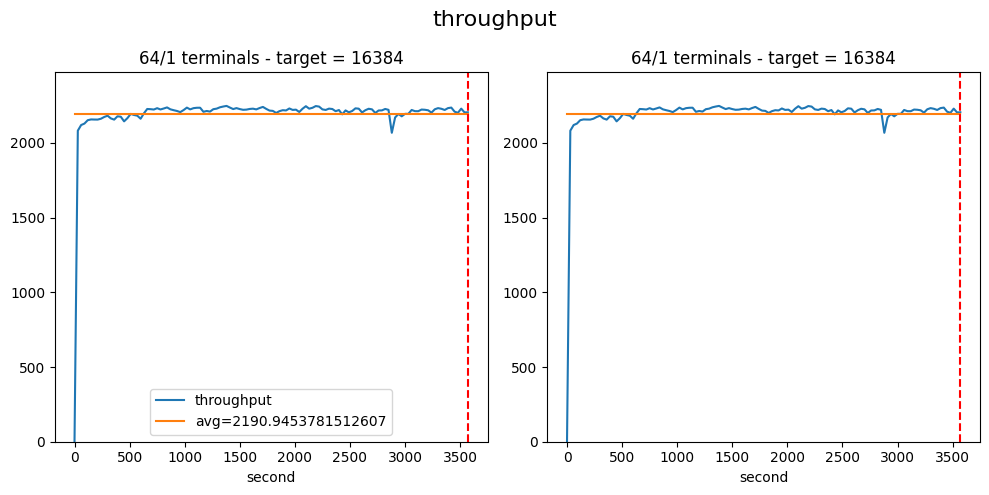

# Metric throughput

## Configuration Citus-1-1-1024

### Experiment run 1

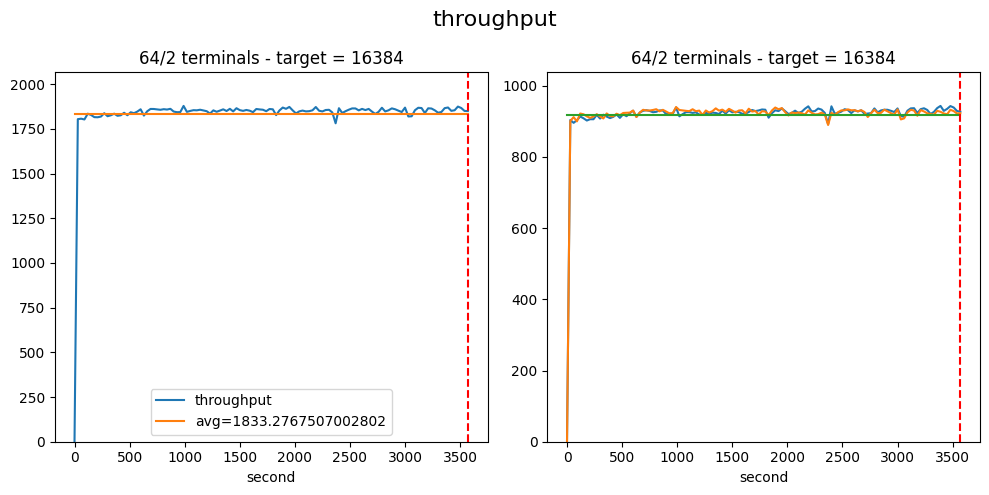

# Metric throughput

## Configuration Citus-1-1-1024

### Experiment run 1

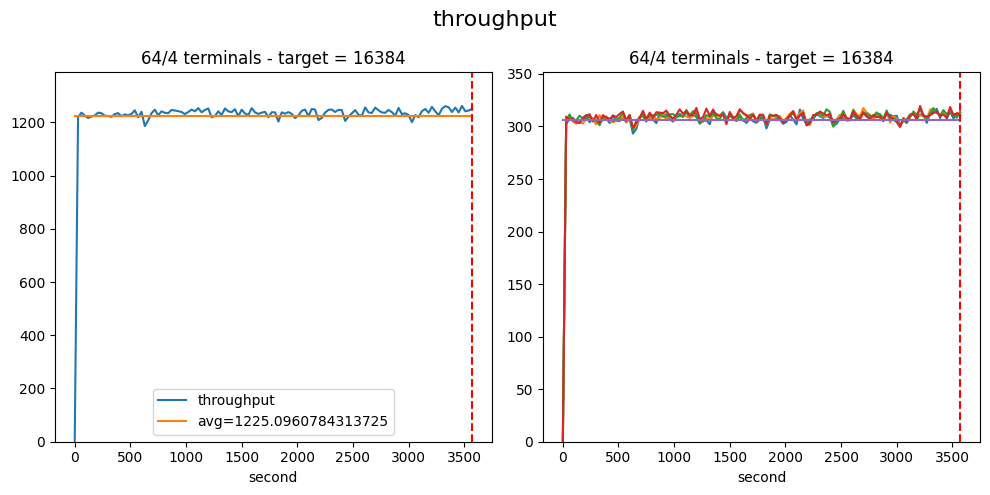

# Metric throughput

## Configuration Citus-1-1-1024

### Experiment run 1

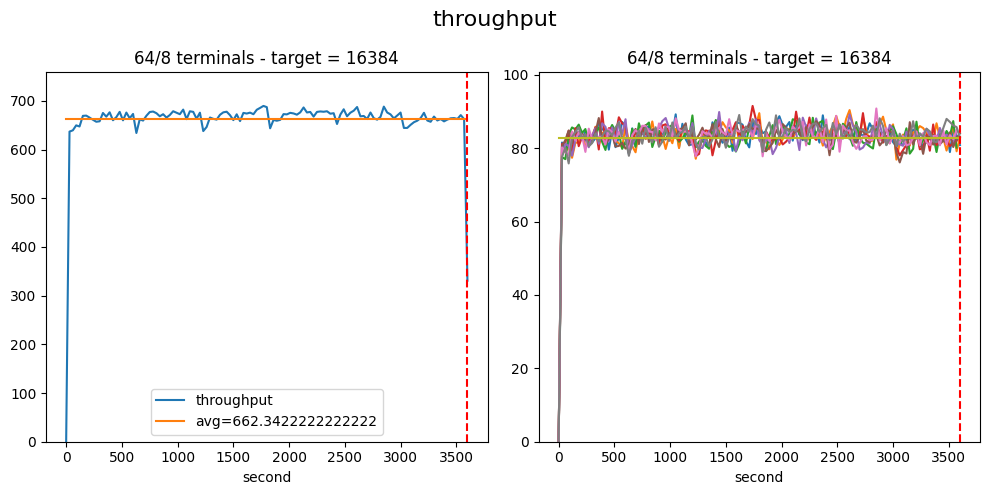

In [26]:
pod_count = 1
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, terminals=terminals, smoothing=0)
pod_count = 2
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, terminals=terminals, smoothing=0)
pod_count = 4
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, terminals=terminals, smoothing=0)
pod_count = 8
plot_timeseries(df_aggregated, metric, pod_count=pod_count, experiment_run=experiment_run, target=target, terminals=terminals, smoothing=0)

## Show Infos about Connections

In [27]:
connections = evaluation.get_connection_config()

print("found", len(connections), "connections")

found 4 connections


In [28]:
import json
pretty_connections = json.dumps(connections, indent=2)

print(pretty_connections)

[
  {
    "version": "10.0.2",
    "alias": "DBMS F",
    "docker_alias": "GP-B",
    "JDBC": {
      "driver": "org.postgresql.Driver",
      "auth": [
        "postgres",
        "password1234"
      ],
      "url": "jdbc:postgresql://bexhoma-sut-citus-1-1-1024-benchbase-128.perdelt.svc.cluster.local:9091/postgres",
      "jar": "./jars/postgresql-42.5.0.jar"
    },
    "active": true,
    "name": "Citus-1-1-1024-1",
    "docker": "Citus",
    "script": "Schema",
    "info": [],
    "timeLoad": 537.0,
    "timeGenerate": 0.0,
    "timeIngesting": 515.0,
    "timeSchema": 2.0,
    "timeIndex": 20.0,
    "script_times": {
      "initschema": 2.0,
      "loaded": 2.0,
      "generated": 0.0,
      "ingested": 515.0,
      "checkschema": 19.0,
      "indexed": 20.0
    },
    "priceperhourdollar": 0.0,
    "hostsystem": {
      "RAM": 541008592896,
      "CPU": "AMD Opteron(tm) Processor 6378",
      "GPU": "",
      "GPUIDs": [],
      "Cores": 64,
      "host": "5.15.0-134-generic",
  

### Loading time per number of loading threads

In [29]:
for c in connections:
    print(c['name'], 
          c['timeLoad'], 
          '[s] for', 
          c['parameter']['connection_parameter']['loading_parameters']['PARALLEL'], 
          'threads on',
          c['hostsystem']['node'])

Citus-1-1-1024-1 537.0 [s] for 1 threads on cl-worker11
Citus-1-1-1024-2 537.0 [s] for 1 threads on cl-worker11
Citus-1-1-1024-3 537.0 [s] for 1 threads on cl-worker11
Citus-1-1-1024-4 537.0 [s] for 1 threads on cl-worker11


## Get monitoring metrics

### Loading

In [30]:
evaluation.transform_monitoring_results()

In [31]:
evaluation.get_monitoring_metrics()

[]

In [ ]:
df = evaluation.get_monitoring_metric('total_cpu_memory')

df.T

In [ ]:
%matplotlib inline
#fig, ax = plt.subplots()
ax = df.plot(kind='line')
#ax.set_ylim(0,df[y].max())
plt.legend(loc='best')
plt.show()


In [ ]:
list_metrics = evaluation.get_monitoring_metrics()
row=0
col=0
rows = (len(list_metrics)+1)//2

fig, axes = plt.subplots(nrows=rows, ncols=2, sharex=True, squeeze=False, figsize=(12,8*rows))
for metric in list_metrics:
    df = evaluation.get_monitoring_metric(metric)
    ax = df.plot(ax=axes[row,col], kind='line', title=metric, layout=(rows,2))
    col = col + 1
    if col > 1:
        row = row + 1
        col = 0
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Benchmarking

In [ ]:
evaluation.transform_monitoring_results(component='stream')

In [ ]:
list_metrics = evaluation.get_monitoring_metrics()
row=0
col=0
rows = (len(list_metrics)+1)//2

fig, axes = plt.subplots(nrows=rows, ncols=2, sharex=True, squeeze=False, figsize=(12,8*rows))
for metric in list_metrics:
    df = evaluation.get_monitoring_metric(metric, component='stream')
    #if df.sum().sum() > 0:
    ax = df.plot(ax=axes[row,col], kind='line', title=metric, layout=(rows,2))
    col = col + 1
    if col > 1:
        row = row + 1
        col = 0
plt.legend(loc='best')
plt.tight_layout()
plt.show()